In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import compute_metric_dc
import nibabel as nib
from sklearn.model_selection import KFold
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
max_epochs = 20
BATCH_SIZE = 8
lr = 0.001
opt = tf.keras.optimizers.Adam(lr)
ver = 'model_self_attention_03' #save version
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords05/'
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack05/"

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs):
    choice = np.random.randint(0,4)
    #no augmentation 
    if choice==0:
        x = imgs 
    #flip up and down 
    if choice==1:
        x = tf.image.flip_up_down(imgs)
    #flip left and right 
    if choice==2:
        x = tf.image.flip_left_right(imgs)
    #rotation based on angle 
    if choice==3:
        n_rot = np.random.randint(1,4)
        x = tf.image.rot90(imgs, k=n_rot)
    return x

---

# Layer Names

In [4]:
# template for guided attention block
layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                  'pam01_alpha','pam01_add']
layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                  'pam02_alpha', 'pam02_add']
layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
layer_name_template = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

layer_name_ga = []
for b in range(1,4):
    layer_block = []
    for layer in layer_name_template:
        layer_internal = [i+'block0{}'.format(b) for i in layer]
        layer_block.append(layer_internal)
    layer_name_ga.append(layer_block)

----

# Model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply, GaussianNoise
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Layer, Softmax, ReLU, PReLU
from tensorflow_addons.layers import GroupNormalization
from utils_model import *
from attention import *

def conv_block_sep_v2(x, filters, layer_name, norm_fn='bn', kernel_size=(3, 3),
               kernel_initializer='glorot_uniform', acti_fn='relu', dropout_rate=None):
    '''
    Dual convolution block with [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: A list that contains the number of filters for 1st and 2nd convolutional layer
    :param layer_name: A list  that contains the name for the 1st and 2nd convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param dropout_rate: Specify dropouts for layers
    :return: Feature maps of same size as input with number of filters equivalent to the last layer
    '''
    assert type(filters)==list, "Please input filters of type list."
    assert type(layer_name)==list, "Please input filters of type list."
    assert acti_fn!= None, 'There should be an activation functino specified'
    #1st convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2])(x)
    x = SeparableConv2D(filters[0], kernel_size, padding='same', kernel_initializer=kernel_initializer, name = layer_name[0])(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    #2nd convolutional block
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2])(x)
    x = SeparableConv2D(filters[1], kernel_size, padding='same', kernel_initializer=kernel_initializer, name = layer_name[1])(x)
    return x


def down_sampling_sep_v2(x, filters, layer_name, norm_fn='bn', kernel_size=(3, 3), acti_fn='relu',
            kernel_initializer='glorot_uniform', dropout_rate=None, mode ='coord', x_dim=None, y_dim=None):
    '''
    Down sampling function version 2 with Convolutional layer of stride 2 as downsampling operation, with
    [full pre-activation], Norm -> Acti -> Conv
    :param x: Input features
    :param filters: Number of filters for Convolutional layer of stride 2
    :param layer_name: Layer name for convolutional layer
    :param norm_fn: Tensorflow function for normalization, 'bn' for Batch Norm, 'gn' for Group Norm
    :param kernel_size: Kernel size for both convolutional layer with 3x3 as default
    :param acti_fn: Tensorflow function for activation, 'relu' for ReLU, 'prelu' for PReLU
    :param kernel_initializer: Initializer for kernel weights with 'glorot uniform' as default
    :param dropout_rate: Specify dropouts for layers
    :param mode: 'coord' for Seperable Coord Conv, 'normal' for Seperable Conv
    :param x_dim: x dimension for coord conv
    :param y_dim: y dimension for coord conv
    :return: Feature maps of size scaled down by 2 with number of filters specified
    '''
    assert mode=='coord' or mode=='normal',  "Use 'coord' or 'normal' for mode!"
    assert acti_fn!= None, 'There should be an activation functino specified'
    if norm_fn=='bn':
        x = BatchNormalization()(x)
    elif norm_fn=='gn':
        x = GroupNormalization()(x)
    if acti_fn=='relu':
        x = ReLU()(x)
    elif acti_fn=='prelu':
        x = PReLU(shared_axes=[1,2])(x)
    if mode=='coord':
        #seperable coordconv
        assert (x_dim!=None and y_dim!=None), "Please input dimension for CoordConv!"
        x = Conv2D(1, kernel_size, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
        x = CoordConv(x_dim=x_dim, y_dim=y_dim, with_r=False, filters=filters, strides=(1,1),
                      kernel_size = 3, padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x)
    else:
        #normal mode
        x = SeparableConv2D(filters, kernel_size, strides=(2, 2), padding='same', kernel_initializer=kernel_initializer, name=layer_name)(x)
    if dropout_rate != None:
        x = Dropout(dropout_rate)(x)
    return x

def res_block_sep_v2(x_in, filters,  layer_name, norm_fn='gn', kernel_size=(3, 3),
               kernel_initializer='glorot_uniform', acti_fn='prelu', dropout_rate=None):
    assert len(filters)==2, "Please assure that there is 2 values for filters."
    assert len(layer_name)==3, "Please assure that there is 3 values for layer name"
    layer_name_conv = [layer_name[i] for i in range(len(layer_name)-1)]
    output_conv_block = conv_block_sep_v2(x_in, filters, layer_name_conv, norm_fn=norm_fn, kernel_size=kernel_size,
                                   kernel_initializer = kernel_initializer, acti_fn = acti_fn, dropout_rate=dropout_rate)
    output_add = Add(name = layer_name[-1])([output_conv_block, x_in])
    return output_add

def guided_attention_block(inp_feature, layer_name_p, layer_name_c):
    '''
    Guided attention block that takes feature as input and concatenates features
    from PAM and CAM as output
    :param inp_feature: Input features
    :param layer_name_p: layer name list for PAM
    :param layer_name_c: layer name list for CAM
    :return: squeezed concatenated features of PAM and CAM
    '''
    pam_feature = PAM(inp_feature, layer_name_p, kernel_initializer=hn)
    cam_feature = CAM(inp_feature, layer_name_c)
    add = Add()([pam_feature,cam_feature]) #[60,60,128]
    up = UpSampling2D(size=(4,4))(add) #[240,240,128]
    squeeze = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn,
                       activation='relu')(up)
    return squeeze

def guided_attention(res_feature, ms_feature, layer_name):
    '''
    Guided attention module
    :param res_feature: Upsampled Feature maps from Res Block
    :param ms_feature: Multi scale feature maps result from Res Block
    :param layer_name: Layer Name should consist be a list contating 4 list
    Example:
    layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                      'pam01_alpha','pam01_add']
    layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
    layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                      'pam02_alpha', 'pam02_add']
    layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
    layer_name = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

    :return: guided attention module with shape same as input
    '''
    assert len(layer_name)==4, "Layer name should be a list consisting 4 lists!"
    #self attention block01
    concat01 = concatenate([res_feature, ms_feature], axis=-1)
    squeeze01 = guided_attention_block(concat01, layer_name[0], layer_name[1])
    multi01 = Multiply()([squeeze01, ms_feature])
    #self attention block02
#     concat02 = concatenate([multi01, res_feature],axis=-1)
#     squeeze02 = guided_attention_block(concat02, layer_name[2], layer_name[3])
    return multi01

def forward(x):
    '''
    Resnet as backbone for multiscale feature retrieval.
    Each resblock output(input signal), next resblock output(gated signal) is
    feed into the gated attention for multi scale feature refinement.
    Each gated attention output is pass through a bottle neck layer to standardize
    the channel size by squashing them to desired filter size of 64.
    The features are upsampled at each block to the corresponding [wxh] dimension
    of w:240, h:240.
    The upsampled features are concat and squash to corresponding channel size of 64
    which yield multiscale feature.
    :param x: batched images
    :return: feature maps of each res block
    '''
    #inject noise
    gauss1 = GaussianNoise(0.01)(x)
    #retrieve input dimension
    b,w,h,c = x.shape
    #---- ResNet and Multiscale Features----
    #1st block
    conv01 = CoordConv(x_dim=w, y_dim=h, with_r=False, filters=64, strides=(1,1),
                      kernel_size = 3, padding='same', kernel_initializer=hn, name='conv01')(gauss1)
    res_block01 = res_block_sep_v2(conv01, filters=[128, 64], layer_name=["conv02", "conv03", "add01"], dropout_rate=dropout)
    #2nd block
    down_01 = down_sampling_sep_v2(res_block01, filters=128, layer_name = 'down_01',  kernel_initializer=hn,
                               mode='normal',x_dim=w//2, y_dim=w//2)
    res_block02 = res_block_sep_v2(down_01, filters=[256, 128], layer_name=["conv04", "conv05", "add02"], dropout_rate=dropout)
    #3rd block
    down_02 = down_sampling_sep_v2(res_block02, filters=256, layer_name = 'down_02',  kernel_initializer=hn,
                               mode='normal',x_dim=w//4, y_dim=h//4)
    res_block03 = res_block_sep_v2(down_02, filters=[512, 256], layer_name=["conv06", "conv07", "add03"], dropout_rate=dropout)
    #4th block
    down_03 = down_sampling_sep_v2(res_block03, filters=512, layer_name = 'down_03',  kernel_initializer=hn,
                               mode='normal',x_dim=w//8, y_dim=h//8)
    res_block04 = res_block_sep_v2(down_03, filters=[1024, 512], layer_name=["conv08", "conv09", "add04"], dropout_rate=dropout)
    # *apply activation function for the last output
    res_block04 = PReLU(shared_axes=[1,2])(res_block04)
    #grid attention blocks
    att_block01 = attention_block(res_block01,res_block02,64,'grid_att01')
    att_block02 = attention_block(res_block02,res_block03,128,'grid_att02')
    att_block03 = attention_block(res_block03, res_block04,256,'gird_att03')
    #bottle neck => layer squash all attention block to same filter size 64
    bottle01 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block01)
    bottle02 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block02)
    bottle03 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block03)
    #upsampling for all layers to same (wxh) dimension=>240x240
    up01 = bottle01 #[240,240,64]
    up02 = UpSampling2D(size=(2, 2), interpolation='bilinear')(bottle02) #[120,120,64]=>[240,240,64]
    up03 = UpSampling2D(size=(4,4), interpolation='bilinear')(bottle03) #[60,60,64]=>[240,240,64]
    #multiscale features
    concat_all = concatenate([up01,up02,up03],axis=-1) #[240,240,3*64]
    #squeeze to have the same channel as upsampled features [240,240,3*64] => [240,240,64]
    ms_feature = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(concat_all)
    #Segmentations from multiscale features *without softmax activation
    seg_01 = Conv2D(4, (1,1), name='seg_01')(up01)
    seg_02 = Conv2D(4, (1,1), name='seg_02')(up02)
    seg_03 = Conv2D(4, (1,1), name='seg_03')(up02)

    #----self guided attention blocks-----
    ga_01 = guided_attention(up01, ms_feature, layer_name_ga[0])
    ga_02 = guided_attention(up02, ms_feature, layer_name_ga[1])
    ga_03 = guided_attention(up03, ms_feature, layer_name_ga[2])
    #Segmentations from guided attention features *without softmax activation
    seg_ga01 = Conv2D(4, (1,1), name='seg_ga01')(ga_01)
    seg_ga02 = Conv2D(4, (1,1), name='seg_ga02')(ga_02)
    seg_ga03 = Conv2D(4, (1,1), name='seg_ga03')(ga_03)
    #outputs for xent losses
    output_xent = [seg_01, seg_02, seg_03, seg_ga01, seg_ga02, seg_ga03]
    #output for dice coefficient loss
    pred_seg = Add()(output_xent)
    output_dice = Softmax()(pred_seg/len(output_xent))
    return output_xent, output_dice

In [6]:
#Build Model
input_layer = Input(shape=(200,200,4))
model = Model(input_layer, forward(input_layer))

In [7]:
xent_logit = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        output_xent, output_dice = model(image, training=True)
        loss_dice = generalized_dice_loss(label, output_dice)
        loss_xents=[]
        for seg in output_xent:
            loss_xent = xent_logit(label, seg)
            loss_xents.append(loss_xent)
        loss_total = sum(loss_xents)+loss_dice
    gradients = tape.gradient(loss_total, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return output_dice, loss_total, gradients

@tf.function
def val_fn(image, label):
    model_output = model(image, training=False)
    loss = custom_loss(label, model_output)
    return model_output, loss

---


Epochs  1



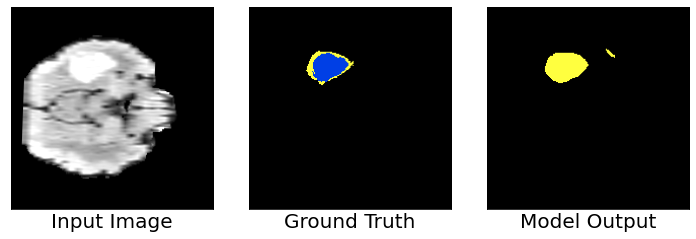

Steps: 5000, Loss:0.5439993143081665
Accurary: 0.9798499941825867
Seq: TC, ET, WT
Dice coefficient: [0.9275, 1.0, 0.9116948832074802]
Gradient min:-0.12145769596099854, max:0.1571456491947174
Compute time per epochs: 64.20 mins

Epochs  2



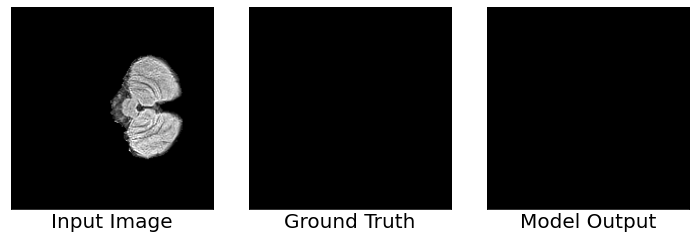

Steps: 5000, Loss:0.3124123513698578
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.03788505494594574, max:0.017866509035229683
Compute time per epochs: 63.29 mins

Epochs  3



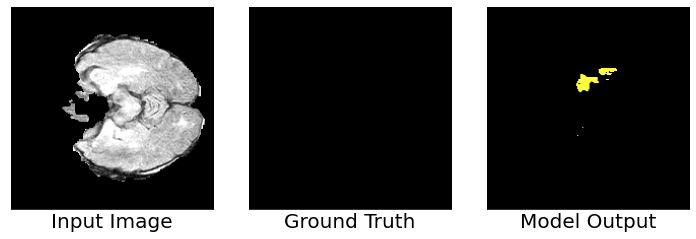

Steps: 5000, Loss:0.2694278657436371
Accurary: 0.9921000003814697
Seq: TC, ET, WT
Dice coefficient: [0.9975, 0.995, 0.955]
Gradient min:-0.06791754812002182, max:0.08400647342205048
Compute time per epochs: 63.65 mins

Epochs  4



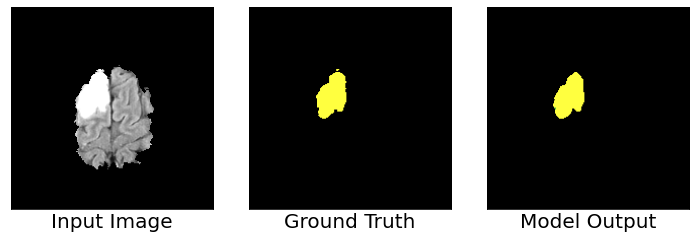

Steps: 5000, Loss:0.32038867473602295
Accurary: 0.9981250166893005
Seq: TC, ET, WT
Dice coefficient: [0.995, 0.99, 0.989407913784186]
Gradient min:-0.053828004747629166, max:0.05141785740852356
Compute time per epochs: 63.65 mins

Epochs  5



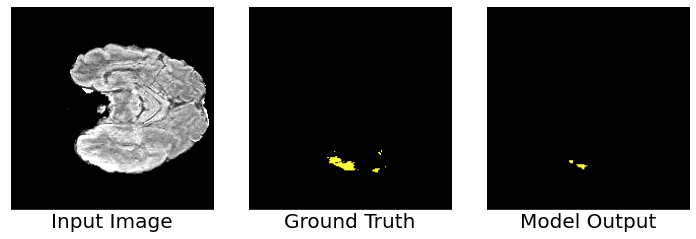

Steps: 5000, Loss:0.4065512418746948
Accurary: 0.9957249760627747
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9713118360936641]
Gradient min:-0.01441463828086853, max:0.020473262295126915
Compute time per epochs: 78.56 mins

Epochs  6



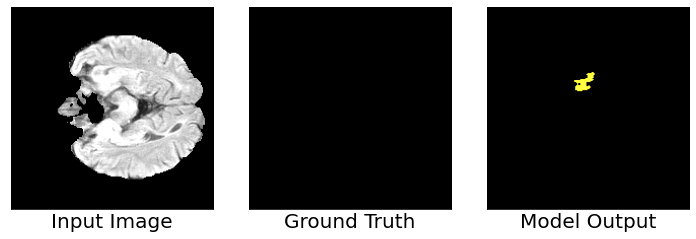

Steps: 5000, Loss:1.1197483539581299
Accurary: 0.9953749775886536
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9683333333333334]
Gradient min:-0.02044050022959709, max:0.01845097728073597
Compute time per epochs: 63.57 mins

Epochs  7



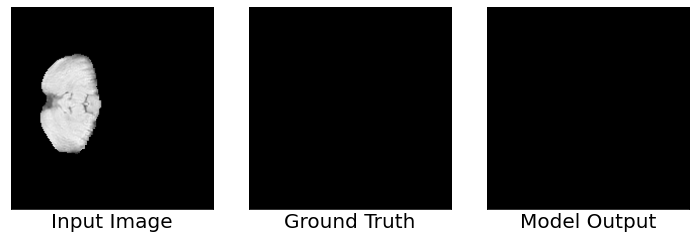

Steps: 5000, Loss:0.5317009091377258
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.022268859669566154, max:0.04111700505018234
Compute time per epochs: 63.68 mins

Epochs  8



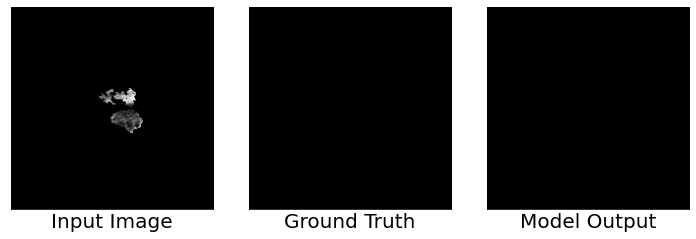

Steps: 5000, Loss:0.20754528045654297
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.0041253287345170975, max:0.009262810461223125
Compute time per epochs: 63.51 mins

Epochs  9



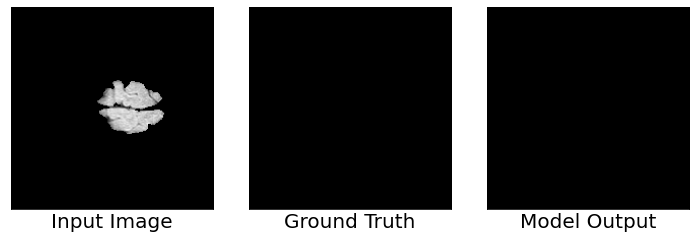

Steps: 5000, Loss:1.2490830421447754
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.03433835878968239, max:0.03400033339858055
Compute time per epochs: 63.52 mins

Epochs 10



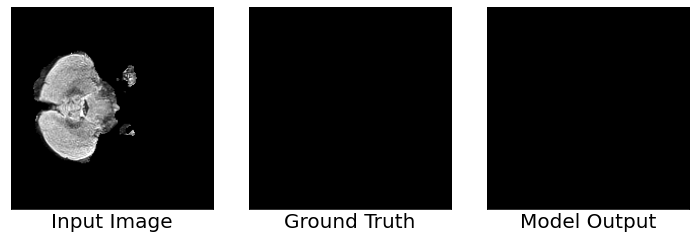

Steps: 5000, Loss:0.31211286783218384
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.0033431893680244684, max:0.005395140033215284
Compute time per epochs: 78.79 mins

Epochs 11



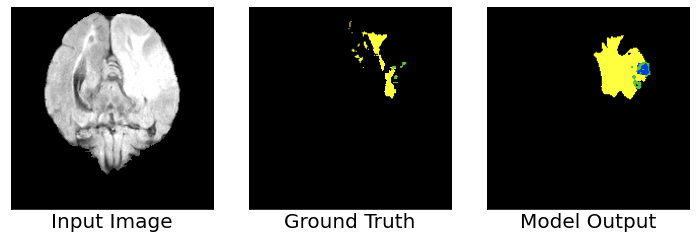

Steps: 5000, Loss:0.8346027731895447
Accurary: 0.9571999907493591
Seq: TC, ET, WT
Dice coefficient: [0.919797924682498, 0.8995958493649959, 0.8663984710226457]
Gradient min:-0.03419120982289314, max:0.04648072272539139
Compute time per epochs: 63.93 mins

Epochs 12



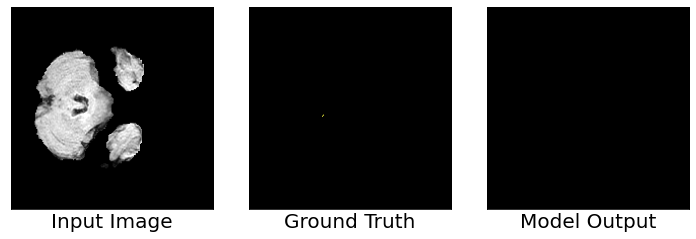

Steps: 5000, Loss:0.4135328531265259
Accurary: 0.9999499917030334
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9966666666666667]
Gradient min:-0.06960088759660721, max:0.16044174134731293
Compute time per epochs: 63.58 mins

Epochs 13



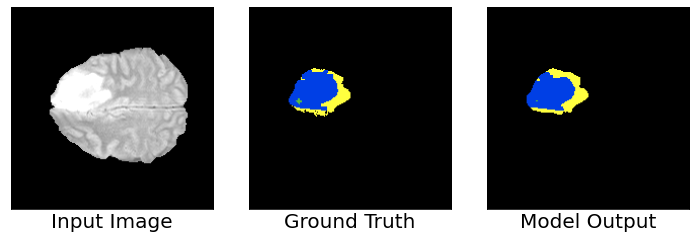

Steps: 5000, Loss:0.6995141506195068
Accurary: 0.9924749732017517
Seq: TC, ET, WT
Dice coefficient: [0.9699902158230543, 0.9725, 0.9609773406634728]
Gradient min:-0.11121726781129837, max:0.032633598893880844
Compute time per epochs: 63.31 mins

Epochs 14


In [ ]:
epochs = 1
#list
loss_list = []
start_runtime = time.time()
while epochs <= max_epochs:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    ds = os.listdir(tfrecords_read_dir)
    #shuffle directory list of tfrecords
    shuffle = random.shuffle(ds)
    loss_inner = []
    for tf_re in ds:
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for imgs in dataset:
            #data augmentation
            imgs = data_aug(imgs)
            #crop images
            image = imgs[:,20:220,20:220,:4]
            #unprocessed label for plotting (cropped)
            label = imgs[:,20:220,20:220,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            #--------------<training function>----------------------------
            img_seg, loss, gradients = train_fn(image, label) 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #store lost for every steps
            loss_inner.append(loss)
            #save weights for every 5 epochs 
            if epochs%5==0:
                model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
            #output
            if steps%5000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp =compute_metric_dc(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Seq: TC, ET, WT")
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
    loss_list.append(np.mean(loss_inner))
    #end time per epochs 
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1
#end time for total epochs
elapsed_time_runtime = (time.time()-start_runtime)/60
print()
print('----------------------------------<END>---------------------------------')
print("Total run time for {} epochs: {:.2f} mins".format(epochs, elapsed_time_runtime))

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    w,h,c = image.shape
    model.trainable = False
    _, model_output = model(image)
    # we need [240,240,155] to input into cloud validation
    if w!=240:
        #padding constant
        p = int(240-w)
        padding = tf.constant([[0,0],[p,p],[p,p],[0,0]]) #p=20
        model_output = tf.pad(model_output, padding, "CONSTANT")
    return model_output

In [ ]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        image = imgs[:,20:220,20:220,:4]
        seg_output = 0 #flush RAM
        seg_output = np.zeros((240,240,155))
        for i in range(image.shape[0]):
            inp = tf.expand_dims(image[i],0)
            img_seg = output_fn(inp) #validation function 
            #map from sparse to label
            seg_output[:,:,i] = np.argmax(img_seg,-1) 
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

---

# Model Summary

In [ ]:
model.summary()